# SMS-Spam-Detection using Naive Bayes Classifier

# 0. Introduction

In this project, we aim to develop a machine learning model to accurately classify text messages as either spam or not spam. The growth of unwanted and often malicious spam messages poses a significant inconvenience and potential security risk to users. The objective is to reduce the number of unwanted messages received by users, enhancing their communication experience.

We will utilize the SMS Spam Collection v.1 dataset, a well-curated collection of 5,574 English text messages. This dataset is  labeled to distinguish between 'ham' (legitimate) and 'spam' messages. The dataset's compilation from different sources ensures a rich variety of text samples, which is crucial for the effectiveness of our classification algorithms.

By leveraging natural language processing (NLP) techniques, we intend to preprocess the text data, extract meaningful features, and apply a classification algorithm to filter out spam.

We will employ two standard methods for text representation: Bag-of-Words (BoW) and Term Frequency-Inverse Document Frequency (TF-IDF). Our process begins with text data preprocessing to ensure consistency and clarity for the model. Following this, we will train Naive Bayes classifiers on both BoW and TF-IDF feature sets.

The effectiveness of our models will be assessed using several metrics, with a particular emphasis on the F1 score due to its ability to balance precision and recall, providing a more comprehensive view of the model's performance.

Ultimately, the success of our model will be determined by its performance on a set of unseen SMS messages. This final testing phase is crucial as it simulates real-world conditions and ensures that our model can effectively identify spam in a live environment.

**Dataset and Resources**

* SMS Spam Collection Dataset: https://archive.ics.uci.edu/dataset/228/sms+spam+collection

# 1. Importing the necessary Modules and reading the Dataset

In [1]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict, Counter
from math import log, sqrt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

df = pd.read_excel('SpamDS.xlsx', header=None, names=['label', 'message'])

The dataset was saved as a .xlsx file due to higher familiarity with data processing using pandas lib.

# 2. Data Preprocessing

## Steps:
Tokenization: Splitting text into individual words or tokens.

Lowercasing: Converting all characters in the text to lowercase to ensure uniformity.

Removing Stop Words: Eliminating common words that do not contribute to the meaning of the text for the analysis.

Stemming: Reducing words to their root form to treat different forms of the same word as equivalent.

Vectorization: Converting text into numerical vectors that ML models can understand. In our approach, this is done using
Bag-of-Words (BoW) and TF-IDF methods.

In [2]:
# Preprocessing functions
def tokenize(message):
    return re.findall(r'\b\w+\b', message.lower())

def remove_stop_words(tokens):
    stop_words = set('for a of the and to in'.split())  # This set can be expanded
    return [t for t in tokens if t not in stop_words]

def stem(tokens):
    # A simple stemmer 
    return [re.sub(r'(ing|ly|ed|ious|ies|ive|es|s|ment)$', '', t) for t in tokens]

def get_vocabulary(messages):
    vocabulary = set()
    for message in messages:
        for token in message:
            vocabulary.add(token)
    return vocabulary

# BoW feature extraction
def vectorize_bow(messages, vocabulary):
    vocabulary = list(vocabulary)
    vectors = np.zeros((len(messages), len(vocabulary)))
    for i, message in enumerate(messages):
        message_counts = Counter(message)
        for token, count in message_counts.items():
            if token in vocabulary:
                vectors[i, vocabulary.index(token)] = count
    return vectors

# TF-IDF feature extraction
def vectorize_tfidf(messages, vocabulary):
    word_indices = {word: i for i, word in enumerate(vocabulary)}
    word_counts_per_sms = [Counter(message) for message in messages]
    tf = np.zeros((len(messages), len(vocabulary)))
    idf = np.zeros(len(vocabulary))
    for i, message in enumerate(messages):
        for token in message:
            if token in word_indices:
                tf[i, word_indices[token]] = word_counts_per_sms[i][token] / len(message)
    for i, token in enumerate(vocabulary):
        idf[i] = log(len(messages) / (1 + sum(1 for message in messages if token in message)))
    tfidf = tf * idf
    return tfidf

# 3. Method

## Steps: 

Preprocessing: Apply the preprocessing functions to the dataset.

Vocabulary Creation: Compile a list of all unique words across the cleaned messages to form a vocabulary.

Vectorization: Convert the text messages into numerical vectors using both BoW and TF-IDF functions.

Data Splitting: Divide the dataset into training and testing sets, with an 80/20 split used.

Model Training: Train two separate Naive Bayes classifiers on the training data: one with BoW vectors and the other with TF-IDF vectors.

In [3]:
# Preprocess messages
processed_messages = [stem(remove_stop_words(tokenize(str(message)))) for message in df['message']]

# Create vocabulary
vocabulary = list(get_vocabulary(processed_messages))

# Vectorize messages using BoW
vectors_bow = vectorize_bow(processed_messages, vocabulary)

# Vectorize messages using TF-IDF
vectors_tfidf = vectorize_tfidf(processed_messages, vocabulary)

# Split dataset (80/20)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(vectors_bow, df['label'], test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(vectors_tfidf, df['label'], test_size=0.2, random_state=42)

# Train Naive Bayes classifier using BoW
clf_bow = MultinomialNB()
clf_bow.fit(X_train_bow, y_train)

# Train Naive Bayes classifier using TF-IDF
clf_tfidf = MultinomialNB()
clf_tfidf.fit(X_train_tfidf, y_train)

MultinomialNB()

## Hyperparameters

#### For the Naive Bayes classifier:

alpha: The smoothing parameter. The default is set to 1.0, which indicates Laplace smoothing.

class_prior: Prior probabilities of the classes. If not specified, the classifier assumes uniform priors.

#### For vectorization:
Hyperparameters might include the maximum number of features to include, whether to use n-grams, and the maximum and minimum document frequency thresholds for including words.

#### Decision on hyperparameter optimization:
Since both models achieved accuracy results above 97% without hyperparameter tuning, as you will see shortly below, the decision was to use the default configurations for the MultinomialNB and vectorization.

# 4. Model Evaluation

## Evaluation Metrics:

The models are evaluated using accuracy, precision, recall, and F1 score. Accuracy measures the overall correctness of the model, precision measures the correctness of positive predictions, recall measures the model's ability to find all positive instances, and the F1 score is the harmonic mean of precision and recall. F1 score is usually a more informative metric for this type of task.

In [4]:
# Predict on test set using BoW
y_pred_bow = clf_bow.predict(X_test_bow)

# Predict on test set using TF-IDF
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

# Evaluate the classifier using BoW
accuracy_bow = accuracy_score(y_test, y_pred_bow)
precision_bow, recall_bow, f1_bow, _ = precision_recall_fscore_support(y_test, y_pred_bow, average='binary', pos_label='spam')

# Evaluate the classifier using TF-IDF
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
precision_tfidf, recall_tfidf, f1_tfidf, _ = precision_recall_fscore_support(y_test, y_pred_tfidf, average='binary', pos_label='spam')

print(f'BoW Accuracy: {accuracy_bow:.2f}')
print(f'BoW Precision: {precision_bow:.2f}')
print(f'BoW Recall: {recall_bow:.2f}')
print(f'BoW F1 Score: {f1_bow:.2f}')

print(f'TF-IDF Accuracy: {accuracy_tfidf:.2f}')
print(f'TF-IDF Precision: {precision_tfidf:.2f}')
print(f'TF-IDF Recall: {recall_tfidf:.2f}')
print(f'TF-IDF F1 Score: {f1_tfidf:.2f}')

BoW Accuracy: 0.98
BoW Precision: 0.95
BoW Recall: 0.94
BoW F1 Score: 0.94
TF-IDF Accuracy: 0.97
TF-IDF Precision: 0.92
TF-IDF Recall: 0.82
TF-IDF F1 Score: 0.87


# 5. Findings

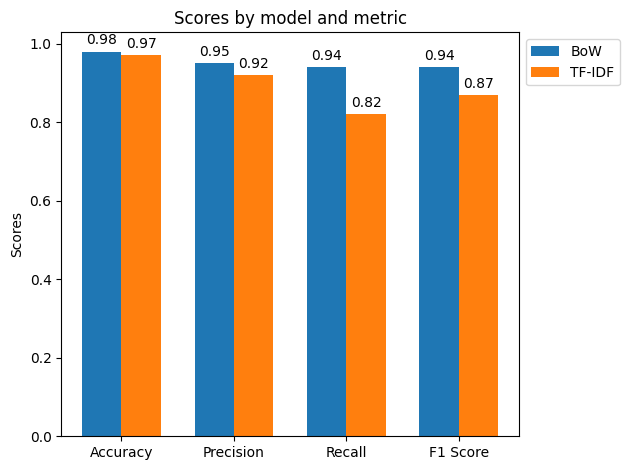

In [5]:
import matplotlib.pyplot as plt

# Performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bow_scores = [0.98, 0.95, 0.94, 0.94]
tfidf_scores = [0.97, 0.92, 0.82, 0.87]

# Set up the bar chart
x = range(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, bow_scores, width, label='BoW')
rects2 = ax.bar([p + width for p in x], tfidf_scores, width, label='TF-IDF')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(metrics)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


# Attach a text label above each bar in rects1 and rects2, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

After analyzing the two text analysis models, we found that the BoW model performed slightly better. It was more accurate in identifying spam messages, with higher scores in precision (correctly identifying spam) and recall (not missing spam messages). The TF-IDF model was also effective but had a bit more trouble in correctly labeling all spam messages, which is reflected in its lower recall score.

Essentially, the BoW model was more reliable for this task. It made fewer mistakes in both detecting spam and avoiding false detections. The bar charts comparison reveals that the BoW model outperformed the TF-IDF model in all evaluated areas, indicating it was more effective for this particular task.

# 6. Drawbacks and Potential Improvements

## Drawbacks:

Both models treat words as independent features, which means they do not capture context or word order.

The TF-IDF model may not perform as well if important words also appear frequently in non-spam messages.

## Potential Improvements:

Experiment with different classifiers, such as Support Vector Machines or deep learning models, which might capture more complex patterns in the data.

Use more advanced NLP techniques like word embeddings that can capture semantic meaning and context.

Fine-tune hyperparameters using techniques like grid search or random search to optimize model performance.

# 7. Using the trained models to make predictions on new text messages

In [6]:
# Create a mapping of word to index based on the existing vocabulary
word_indices = {word: i for i, word in enumerate(vocabulary)}

def preprocess_and_vectorize(input_text, vocabulary, word_indices):
    # Preprocess the input text
    tokens = stem(remove_stop_words(tokenize(input_text)))
    
    # Initialize vectors
    vector_bow = np.zeros(len(vocabulary))
    vector_tfidf = np.zeros(len(vocabulary))
    
    # BoW Vectorization
    token_counts = Counter(tokens)
    for token in tokens:
        index = word_indices.get(token)
        if index is not None:
            vector_bow[index] = token_counts[token]
    
    # TF-IDF Vectorization
    # Calculate Term Frequency (TF)
    tf = {word: count / len(tokens) for word, count in token_counts.items()}
    
    # Calculate Inverse Document Frequency (IDF)
    idf = {word: log((1 + len(processed_messages)) / (1 + sum(1 for message in processed_messages if word in message))) for word in token_counts}
    
    # Calculate TF-IDF
    for token in tokens:
        index = word_indices.get(token)
        if index is not None:
            vector_tfidf[index] = tf[token] * idf[token]
    
    return vector_bow.reshape(1, -1), vector_tfidf.reshape(1, -1)


# List of new messages
messages = [
    "Congratulations! You've been selected for a chance to win a free cruise to the Bahamas! Call 1-800-SPAM-NOW to claim your prize!",
    "URGENT! You have won a 1-week FREE membership in our $100,000 Cash Reward program. Press 1 now to learn more.",
    "You've won a $500 Amazon gift card. Click here to claim now: http://bit.ly/sodmqj before the offer expires!",
    "Hey there! You are lucky today. You've been chosen to receive a 50% discount on our exclusive diet pills. Rush your order at www.geiloffers.com.",
    "FINAL NOTICE: Your account has been selected for a $1000 Walmart gift card. Use code FREE at www.spam-giftcards.com to claim now!",
    "Hi, this is Mom. Can you pick up some milk on your way home? Thanks, love you!",
    "Reminder: Your dentist appointment is scheduled for tomorrow at 3 PM. Please call us if you need to reschedule.",
    "Good morning! Don't forget we have a meeting at 10 AM with the team. Have a great day!",
    "Hi, it's Mike from the gym. Just a heads-up that the gym will be closed for maintenance this Friday.",
    "Your package has been shipped and should arrive by next Wednesday. Track your shipment here: www.DHL.com/track."
]

# Process and predict each message
for input_text in messages:
    # Preprocess and vectorize the new input text
    vector_bow, vector_tfidf = preprocess_and_vectorize(input_text, vocabulary, word_indices)
    
    # Predict using the trained Naive Bayes classifiers
    prediction_bow = clf_bow.predict(vector_bow)
    prediction_tfidf = clf_tfidf.predict(vector_tfidf)
    
    print(f'Message: "{input_text}"')
    print(f'BoW model prediction: {"Spam" if prediction_bow[0] == "spam" else "Not Spam"}')
    print(f'TF-IDF model prediction: {"Spam" if prediction_tfidf[0] == "spam" else "Not Spam"}')
    print('---'*40)

Message: "Congratulations! You've been selected for a chance to win a free cruise to the Bahamas! Call 1-800-SPAM-NOW to claim your prize!"
BoW model prediction: Spam
TF-IDF model prediction: Spam
------------------------------------------------------------------------------------------------------------------------
Message: "URGENT! You have won a 1-week FREE membership in our $100,000 Cash Reward program. Press 1 now to learn more."
BoW model prediction: Spam
TF-IDF model prediction: Spam
------------------------------------------------------------------------------------------------------------------------
Message: "You've won a $500 Amazon gift card. Click here to claim now: http://bit.ly/sodmqj before the offer expires!"
BoW model prediction: Spam
TF-IDF model prediction: Spam
------------------------------------------------------------------------------------------------------------------------
Message: "Hey there! You are lucky today. You've been chosen to receive a 50% discount

# 8. Conclusion

In conclusion, our project successfully implemented and compared two Naive Bayes classifiers using Bag-of-Words and TF-IDF vectorization methods to classify SMS messages as spam or ham. 

The BoW model demonstrated superior performance across all evaluation metrics, particularly in precision and recall, suggesting it is more adept at identifying spam messages in this dataset. While both models showed high accuracy, the TF-IDF model exhibited some limitations, especially in recall, indicating a tendency to miss certain spam messages. 

The final testing on a set of new, unseen messages confirmed the practical applicability of our trained models, with the BoW model consistently outperforming the TF-IDF model. These results underscore the importance of choosing the right feature extraction method in spam detection tasks and highlight areas for future improvement, such as experimenting with more complex models and advanced NLP techniques to capture contextual variations better.